# Makemore
一个自回归模型，根据一张名单中的字符，可以学会怎么生成名字。其实就是学会从字符串推断出下一个字符是什么，从哪个字符开始，在哪个字符处结束

## bigram 
每次只看两个字母，也就是只从一个字母往后推断下一个。
### 1. 用统计方法，统计所有二元字母组合的数量，再直接根据概率推测


In [ ]:
import torch
words = open('names.txt','r').read().splitlines()

N = torch.zeros((27, 27), dtype=torch.int32) # 27*27的张量，dtype指数据类型，横向和纵向都是字母，交点代表字母组合的数量

chars = sorted(list(set(''.join(words)))) # 提取所有的字母，并按字母顺序排列，set()可以避免重复
stoi = {s:i+1 for i,s in enumerate(chars)} # s映射到i，i、s分别代表序号和字母。字母占了1到27位
stoi['.'] =0 # .代表开始与结束
itos = {i:s for s,i in stoi.items()}  # 反过来的映射，序号映射到字母

for w in words:
    chs = ['.'] + list(w) + ['.'] # 每个单词加上开始与结束符号
    for ch1, ch2 in zip(chs, chs[1:]): # 遍历一个单词所有的字母二元组合
        ix1 = stoi[ch1]  # ix是index的意思
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1  # 更新ch1、ch2对应的字母组合的计数



In [ ]:
# 画图展示所有的二元组出现的次数
import matplotlib.pyplot as plt
# %matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off')
plt.show()

In [ ]:
P = (N+1). float() # N可以加一个数，这个方法叫model smoothing，防止有些二元组在张量里面是0。加的这个数越大，就越平滑
P /= P.sum(1, keepdim=True) # P.sum可以把张量压缩到27*1，也就是每行求和。由于广播机制，P(27*27)可以除以P.sum，通过将后者复制拉伸到27*27。这样每行的和为1，每行的元素各自归一化了。这里有一个tricky的地方，如果keepdim=False，那么就压缩到一维，广播是为了对齐会把P.sum拉伸成1*27，就变成每列归一化了，但是我们之后所取的概率分布是每行的，所以就会出问题

g = torch.Generator().manual_seed(2147483647) # generator是一个随机数生成器对象，用于控制随机操作的可重复性和随机性来源
for i in range(20):
    out = []
    ix = 0 # 开始时取“.”,也就是字符串开始的符号
    while True:
        # p = N[ix].float()
        # p = p / p.sum( )  # p是概率分布
        p = P[ix] # 提高效率的方法。p取的是第ix行
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item() # 从概率分布 p中随机抽样；只抽取 1 个样本；有放回抽样，允许同一索引被多次选中；使用特定的随机数生成器 g控制随机性；item表示从单元素张量中提取出 Python 标量（整数），例如将 tensor([2])转换为 2
        out.append(itos[ix])  # 输出对应ix的字母
        if ix == 0: # 到达.就停
            break
    print("".join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.


In [ ]:
# 如何评判这个方法的好坏。这里使用最大似然的方法，根据已有的names.txt，将要检查的名字中所有二元组的概率乘起来得到一个概率，越接近1越好

# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

log_likelihood = 0.0
n= 0 # 二元组的数量
for w in ['qinqi']:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob) # 用log是因为有些值实在太小了
        log_likelihood += logprob
        n += 1
        # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood  # 负的loglikelihood，这样nll可以用来量化损失函数，该函数越小我们的模型越好。nll的取值范围是0到无穷
print(f'{nll=}')
print(f'{nll/n}')  # 最后的loss

log_likelihood=tensor(-24.7678)
nll=tensor(24.7678)
4.127970218658447


### 2. 神经网络方法
神经网络的方法可以扩展，不再局限于二元数组，可以同时考虑输入多个字符之后再预测下一个字符。但是上一种基于统计的方法，如果扩展了以后概率的矩阵内会非常大，不太可行

In [ ]:
# create the training set of bigrams (x,y)
# 创建数据集
xs, ys = [], []

# 跟上面一个方法的代码一样
for w in words[:]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)

# xs和ys储存所有的二元组的前后两个字母，也就是前一个作为输入，后一个作为神经网络需要推断的输出
xs = torch.tensor(xs) # torch.tensor自动推断 dtype，torch.Tensor默认为 torch.float32。xs,ys都是一维的张量
ys = torch.tensor(ys)

num = xs.nelement() # 所有用来训练的例子的数量
print('number of examples: ', num)

. e
e m
m m
m a
a .
. o
o l
l i
i v
v i
i a
a .
. a
a v
v a
a .
. i
i s
s a
a b
b e
e l
l l
l a
a .
. s
s o
o p
p h
h i
i a
a .
. c
c h
h a
a r
r l
l o
o t
t t
t e
e .
. m
m i
i a
a .
. a
a m
m e
e l
l i
i a
a .
. h
h a
a r
r p
p e
e r
r .
. e
e v
v e
e l
l y
y n
n .
. a
a b
b i
i g
g a
a i
i l
l .
. e
e m
m i
i l
l y
y .
. e
e l
l i
i z
z a
a b
b e
e t
t h
h .
. m
m i
i l
l a
a .
. e
e l
l l
l a
a .
. a
a v
v e
e r
r y
y .
. s
s o
o f
f i
i a
a .
. c
c a
a m
m i
i l
l a
a .
. a
a r
r i
i a
a .
. s
s c
c a
a r
r l
l e
e t
t t
t .
. v
v i
i c
c t
t o
o r
r i
i a
a .
. m
m a
a d
d i
i s
s o
o n
n .
. l
l u
u n
n a
a .
. g
g r
r a
a c
c e
e .
. c
c h
h l
l o
o e
e .
. p
p e
e n
n e
e l
l o
o p
p e
e .
. l
l a
a y
y l
l a
a .
. r
r i
i l
l e
e y
y .
. z
z o
o e
e y
y .
. n
n o
o r
r a
a .
. l
l i
i l
l y
y .
. e
e l
l e
e a
a n
n o
o r
r .
. h
h a
a n
n n
n a
a h
h .
. l
l i
i l
l l
l i
i a
a n
n .
. a
a d
d d
d i
i s
s o
o n
n .
. a
a u
u b
b r
r e
e y
y .
. e
e l
l l
l i
i e
e .
. s
s t


In [ ]:
import torch.nn.functional as F


g = torch.Generator().manual_seed(2147483647)
W= torch.randn((27, 27), generator=g, requires_grad=True) # W是权重，只构建一层的神经网络。randn是随机正态分布，初始是27*27的随机数。需要储存grad，因为待会儿要训练它

for k in range(1000):

    # forward pass 正向传播
    xenc = F.one_hot(xs, num_classes=27).float() # 独热编码所有的输入，这样方便神经网络计算。直接将xs这个张量里的数转换成one-hot里的index。生成的是x_encoded，一个xs*27的张量，也就是每一行代表一个字母。需要手动转换为浮点数
    # plt.imshow(xenc) # 展示该张量的热图
    logits = xenc @ W # predict log-counts。@是矩阵乘法的意思，输出一个xs*27的张量。logits代表次数count的log形式
    counts = logits.exp() # counts, equivalent to N，N是上一种方法中统计二元组次数的矩阵，相当于给logits弄一个指数运算
    probs = counts / counts.sum(1, keepdims=True) # 每一行归一化，每一行代表从这一行原先字母预测出的下一个字母的概率分布
        # btw: 上两行其实就是softmax'
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # 定义损失函数，计算方法和第一种方法中最后的loss是一回事。其中，probs[torch.arange(5), ys]可以提取预测概率分布probs中所有的需要拿来跟ground_truth作比较的概率值，比如ground_truth是c，就提取概率分布probs中第三个位置的概率。最后再加了个正则化项，0.01是正则化的强度，解释看总结
    print(loss.item())

    # backward pass 反向传播
    W.grad = None # set to zero the gradient。清空梯度
    loss.backward()

    # 更新权重
    W.data += -10 * W.grad




    # 总结一下。其实神经网络方法中的权重矩阵W，到最后优化结束会发现，其实就是上一种统计方法中的统计二元次数的矩阵N的对数形式，因为在运算logits = xenc @ W中，xenc是一个独热矩阵，假设xenc第5个元素使1，其他都是0，那么本质上矩阵乘法就是在提取W的第5行的所有概率(可理解为排序第5个的字母可预测出的所有下一个字母的概率)
    # W全为0，可以看做是在label smoothing，这样所有logits为0，logits指数运算以后的counts就全为1，进而使所有概率趋向于均匀分布，和上一种统计方法中加一个很大的数来达到平滑是一个道理。这一目标其实可以通过正则化来实现，即在loss中要求W要越接近0越好


3.7686190605163574
3.6794421672821045
3.5999374389648438
3.528468370437622
3.463968515396118
3.4056591987609863
3.352914571762085
3.305180788040161
3.261941909790039
3.222700595855713
3.186985969543457
3.1543641090393066
3.124450206756592
3.0969085693359375
3.0714569091796875
3.047856569290161
3.025909900665283
3.005449056625366
2.9863314628601074
2.968435287475586
2.951653242111206
2.935891628265381
2.92106556892395
2.907099962234497
2.8939261436462402
2.881481885910034
2.869711399078369
2.858562707901001
2.8479881286621094
2.8379459381103516
2.8283965587615967
2.819303512573242
2.810634136199951
2.8023593425750732
2.7944512367248535
2.7868854999542236
2.7796385288238525
2.7726891040802
2.766019344329834
2.7596113681793213
2.753448247909546
2.747516393661499
2.7418017387390137
2.7362918853759766
2.730975389480591
2.7258412837982178
2.7208809852600098
2.7160847187042236
2.711444854736328
2.7069520950317383
2.7026009559631348
2.6983847618103027
2.6942965984344482
2.690331220626831
2.686

In [47]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):

    out = []
    ix = 0
    while True:
        # 第一种方法:
        #p = P[ix]
        # NOW:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True) # probabilities for next character

        # 这后面都一样
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out)) # 输出应该是差不多的，因为到最后概率分布其实是相同的

junide.
janasah.
prelay.
a.
nn.


## MLP
![image.png](D:\我的文件\DeepLearning\A. Karpathy\微信图片_20260209094750.png)

In [112]:
import torch
import torch.nn. functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# read in all the words
words = open('names.txt', 'r').read().splitlines()



In [113]:
# build the vocabulary of characters and mappings to/from integers
# 和bigram方法中构建一样的映射
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)


# 数据集  
# 要分割成训练集、验证集、测试集（80%、10%、10%）
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:
        #print (w)
        context = [0] * block_size   # context指的是你想要推断的那个字母所依据的上文，这里设定为4，也就是根据前3个字母推断下一个字母。最开始全是0，也就是全是“.”
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)   # ix是在context后的那个字母的index
            #print(''.join(itos[i] for i in context), ' --- >', itos[ix])
            context = context[1:] + [ix] # crop and append。类似于滑动窗口，向后滑一格

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)  # 打乱列表顺序
n1= int(0.8*len(words))
n2= int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])   # 训练集
Xdev, Ydev = build_dataset(words[n1:n2]) # 验证集
Xte, Yte = build_dataset(words[n2:]) # 测试集


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [114]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g) # 27*2，每一行是由两个数字组成的对一个字母的嵌入

# 第一层
W1 = torch.randn((6, 300), generator=g)
b1 = torch. randn(300, generator=g)
# 第二层
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # number of parameters in total

10281

In [115]:

lre = torch.linspace(-3, 0, 1000) # 设置不同的学习率，看哪个学习率好。指数间隔。
lrs = 10 ** lre

In [116]:
lri = []
lossi = []
stepi = []


for i in range(10000):

    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,)) # 生成一个一维张量，包含32个从0到Xtr.shape[0]（也就是Xtr中三元字母组合的数量）中的序号。本质上意思就是每次抽取32个拿来训练

    # 正向传播
    emb = C[Xtr[ix]] # 嵌入层，通过索引查询到Xtr这个张量中每个元素的嵌入。emb的形状torch.Size([32, 3, 2])，32是X中三元字母组的数量
    h= torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 300)   # emb.view(-1,6)这种方法能更好地转换形状，效率高于cat，因为它直接转换内存管理的方式。-1这个参数表示让torch自己推断这一维的数。torch.cat(torch.unbind(emb, 1),1) 同样可以有相同的效果，unbind去除emb的第二个维度，变成3个torch.Size([32, 2])的tensor组成的tuple，之后再沿第二维concatenate，变成32*6，方便与权重相乘。同样相当于torch.cat([emb[:, 0,:], emb[:, 1,:], emb[:, 2,:]], 1).shape，但是不用再显式地写出维第二维的数量
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Ytr[ix]].log().mean()   # 这几行构建loss的方法和bigram里面一样
    loss = F.cross_entropy(logits,Ytr[ix],reduction='mean') # 上面注释中的三行可以合并写为交叉熵损失，计算更高效。默认reduction是meaning，也就是计算出来的结果会取均值

    # 反向传播
    for p in parameters:
        p.grad = None
    loss.backward()

    # 更新权重
    # lr = lrs[i]
    lr = 0.1 # 经过试验，发现取0.1比较好
    for p in parameters:
        p.data += -lr * p.grad

    # # 记录不同学习率时loss的变化
    # lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)

print(loss.item())



2.402568817138672


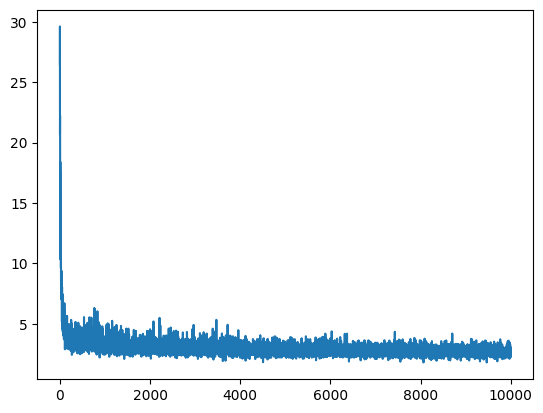

In [117]:
# 用来显示训练过程中loss随学习率的变化
# plt.plot(lri,lossi)

# 展示训练中loss的随步数的变化
plt.plot(stepi,lossi)
plt.show()

# 结果显示lr在10**-1的地方比较好

In [118]:
# 验证
emb = C[Xdev] 
h= torch.tanh(emb.view(-1, 6) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits,Ydev,reduction='mean') 
loss

tensor(2.5402, grad_fn=<NllLossBackward0>)

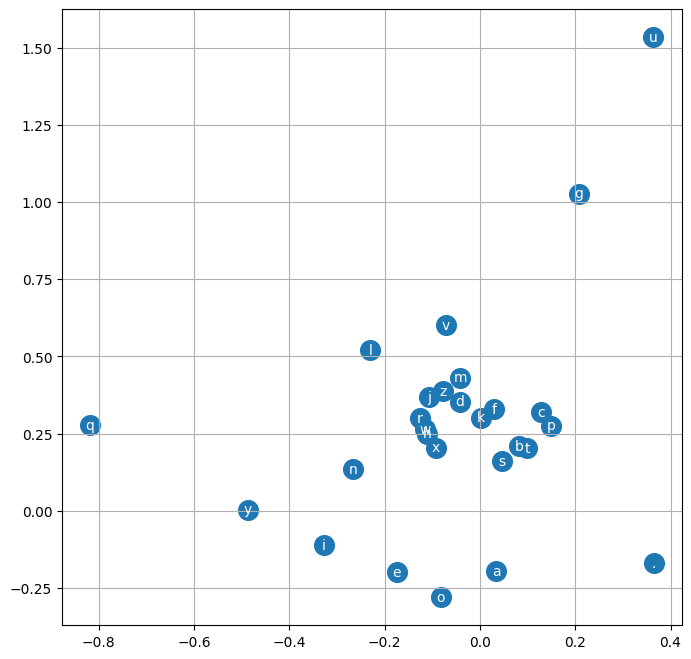

In [119]:
# 因为嵌入层设置是二维的，所以这里我们可以可视化看一下
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
plt.show()

In [120]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h= torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

eria.
mayay.
see.
med.
ryah.
remyas.
badra.
malie.
edielii.
smi.
jen.
edeiseanaxar.
emy.
kasmael.
nysa.
bergavimie.
tri.
jesely.
panten.
mauraen.
